In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# STEP 1: Load the cleaned data
df = pd.read_csv('diabetic_data_cleaned.csv')

# Show data
print(f"Total patients: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(df.head())

Total patients: 101,763
Columns: 48
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...     

In [3]:
df.columns


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

In [10]:
# STEP 2: Select features for prediction 
# These features we'll use based on EDA
feature_columns = [
    'time_in_hospital',
    'num_medications',
    'num_procedures',
    'number_diagnoses',
    'num_lab_procedures',
    'discharge_disposition_id',
    'admission_type_id',
    'admission_source_id'
]

# Create X (features) and Y (target)
# df[feature_columns]: select multiple columns from the dataframe based on the list
# the result is a new dataframe with selected columns
# copy() : create an independent copy of that subset
X = df[feature_columns].copy()

# 1 is readmitted within 30 (<=30), 0: not
Y = (df['readmitted'] == '<30').astype(int)

print("="*70)
print(f"0 = NOT readmitted within 30 days: {(Y==0).sum():,} patients ({(Y==0).sum()/len(Y):.1%})")
print(f"1 = Readmitted within 30 days: {(Y==1).sum():,} patients ({(Y==1).sum()/len(Y):.1%})")
print("="*70)

0 = NOT readmitted within 30 days: 90,406 patients (88.8%)
1 = Readmitted within 30 days: 11,357 patients (11.2%)


In [18]:
## STEP 3: Split into Training and Test Sets
# Split 80% training, 20% testing
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,  # hold pout 20% of patients for testing
    random_state = 42, # "seed" : make random split reproducible 
    stratify = Y # ensure both train and test sets have 11.16 readmission rate
)

print("="*70)
print(f"\nTraining set: {len(X_train):,} patients({len(X_train)/len(X):.1%})")
print(f" - Not readmitted: {(Y_train==0).sum():,}")
print(f" - Readmitted: {(Y_train==1).sum():,}")
print(f" - Readmission rate: {Y_train.mean():.2%}")

print(f"\nTest set: {len(X_test):,} patients({len(X_test)/len(X):.1%})")
print(f" - Not readmitted: {(Y_test==0).sum():,}")
print(f" - Readmitted: {(Y_test==1).sum():,}")
print(f" - Readmission rate: {Y_test.mean():.2%}")
print("="*70)




Training set: 81,410 patients(80.0%)
 - Not readmitted: 72,324
 - Readmitted: 9,086
 - Readmission rate: 11.16%

Test set: 20,353 patients(20.0%)
 - Not readmitted: 18,082
 - Readmitted: 2,271
 - Readmission rate: 11.16%


In [19]:
# STEP 4: Train the model
from sklearn.linear_model import LogisticRegression

# Create model
model = LogisticRegression(
    max_iter = 1000, # iterations to find best formula
    random_state = 42,
    class_weight='balanced' # tell model to pay attention to the 11% readmitted patients
)

# Train the model
# The model will look at 81410 patients and learn when time_in_hospital is high,
# num_procedures = 1, readmission risk increases
model.fit(X_train, Y_train)















,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [28]:
## STEP 5: Model Predictions

#Note:
# y_test: pandas series/df -> use .iloc for position-based access [e.g: y_test.iloc[i]]
# y_pred is a numpy array -> use direct indexing [e.g: y_pred[i]]

# Make predictions
Y_pred = model.predict(X_test) # predict 0 or 1 for each test patient
Y_pred_proba = model.predict_proba(X_test)[:, 1] # probability of readmission (0-1)

print("="*70)
# Show example predictions
for (i) in range(100):
    # y_test.iloc[i] : get the value at position i in y_test which is 0 or 1
    # if the y_test.iloc[i] = 1 -> 1 == 1 : True -> actual = "Readmitted"
    actual = "Readmitted" if Y_test.iloc[i] == 1 else "Not Readmitted"
    predicted = "Readmitted" if Y_pred[i] == 1 else "Not Readmitted"
    prob = Y_pred_proba[i]
    match = "YES" if Y_test.iloc[i] == Y_pred[i] else "NO"
    print(f"Patient {i+1}: Actual={actual:17} | Predicted = {predicted:15} | Probability={prob:.2%}")
print("="*70)

Patient 1: Actual=Readmitted        | Predicted = Readmitted      | Probability=51.40%
Patient 2: Actual=Not Readmitted    | Predicted = Not Readmitted  | Probability=35.09%
Patient 3: Actual=Not Readmitted    | Predicted = Readmitted      | Probability=50.79%
Patient 4: Actual=Readmitted        | Predicted = Readmitted      | Probability=62.15%
Patient 5: Actual=Not Readmitted    | Predicted = Not Readmitted  | Probability=45.20%
Patient 6: Actual=Not Readmitted    | Predicted = Not Readmitted  | Probability=43.43%
Patient 7: Actual=Not Readmitted    | Predicted = Not Readmitted  | Probability=46.78%
Patient 8: Actual=Not Readmitted    | Predicted = Readmitted      | Probability=58.06%
Patient 9: Actual=Not Readmitted    | Predicted = Not Readmitted  | Probability=45.71%
Patient 10: Actual=Not Readmitted    | Predicted = Not Readmitted  | Probability=38.70%
Patient 11: Actual=Not Readmitted    | Predicted = Readmitted      | Probability=55.17%
Patient 12: Actual=Not Readmitted    | Pr

In [36]:
# Calculate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("="*70)
accuracy= accuracy_score(Y_test, Y_pred)
print(f"\nOverall Accuracy: {accuracy:.2%}")

# Confusion Matrix
matrix = confusion_matrix(Y_test, Y_pred)
print(f" True Negatives (correctly predicted NO): {matrix[0,0]:,})")
print(f" False Negatives (predicted NO, actual YES): {matrix[1,0]:,})")
print(f" True Positives (correctly predicted YES): {matrix[1,1]:,})")
print(f" False Positives (predicted YES, actual NO): {matrix[0,1]:,})")
print("="*70)
# Detail Metric
print(classification_report(Y_test, Y_pred, target_names=['Not Readmitted', 'Readmitted']))


Overall Accuracy: 55.09%
 True Negatives (correctly predicted NO): 9,950)
 False Negatives (predicted NO, actual YES): 1,008)
 True Positives (correctly predicted YES): 1,263)
 False Positives (predicted YES, actual NO): 8,132)
                precision    recall  f1-score   support

Not Readmitted       0.91      0.55      0.69     18082
    Readmitted       0.13      0.56      0.22      2271

      accuracy                           0.55     20353
     macro avg       0.52      0.55      0.45     20353
  weighted avg       0.82      0.55      0.63     20353



number_diagnoses               +0.0652 Increases readmission risk
num_procedures                 -0.0526 Decreases readmission risk
time_in_hospital               +0.0251 Increases readmission risk
discharge_disposition_id       +0.0241 Increases readmission risk
admission_type_id              -0.0136 Decreases readmission risk
num_medications                +0.0095 Increases readmission risk
admission_source_id            +0.0026 Increases readmission risk
num_lab_procedures             +0.0002 Increases readmission risk


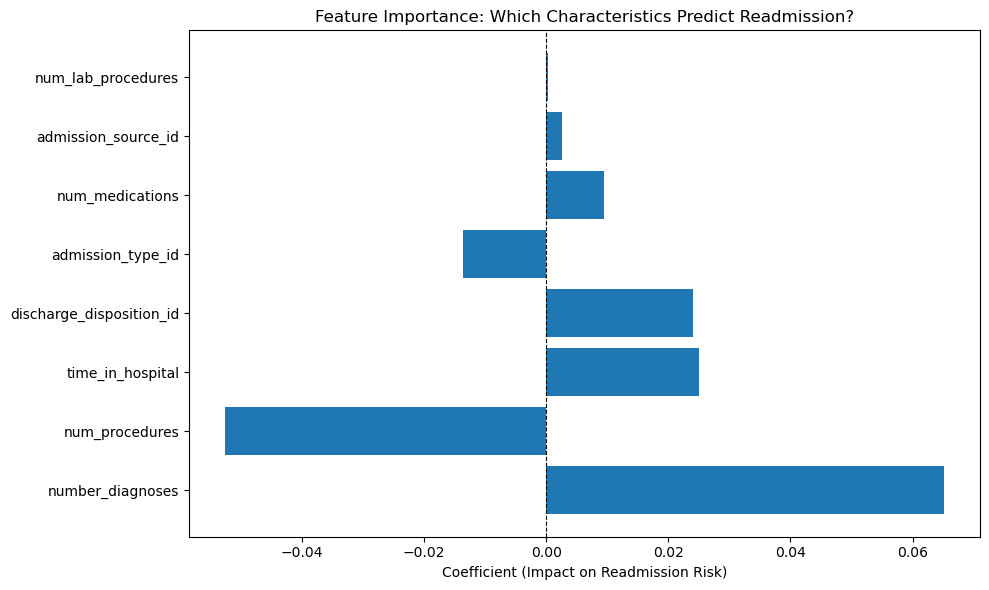

In [40]:
## STEP 6: Feature Importance
# This show which patient characteristics the model think are the most predictive of readmission
import matplotlib.pyplot as plt

# Get feature importance (coefficients from logistic regression
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_[0] 
}).sort_values('Coefficient', key=abs, ascending=False)

print("="*80)
# Iterate over rows
for idex, row in feature_importance.iterrows():
    direction = "Increases" if row['Coefficient'] > 0 else "Decreases"
    print(f"{row['Feature']:30} {row['Coefficient']:+.4f} {direction} readmission risk")

# Visualize the feature importance
# Create a blank canvas with 10 inches wide, 6 inches tall
plt.figure(figsize=(10,6))

# horizontal bar chart (plt.barh)
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient (Impact on Readmission Risk)')
plt.title('Feature Importance: Which Characteristics Predict Readmission?')
# draw a vertical line at x= 0
plt.axvline(x=0, color='black', linestyle='--',linewidth=0.8)
# auto adjust spacing so nothing gets cut off
plt.tight_layout()
# display the plot
plt.show()
